# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed-celeba-small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    transformations = transforms.Compose([transforms.Resize(image_size), 
                                        transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, transform=transformations)
    dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

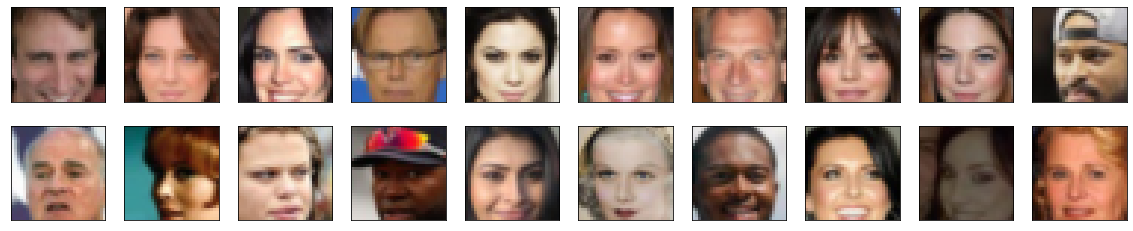

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = (max - min) * x + min
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(0.5843)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False))
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
    
    
    
    # using Sequential container
    return nn.Sequential(*layers)

In [11]:

class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # 32x32 in
        self.conv0 = conv(3, conv_dim, kernel_size=3, stride=1, batch_norm=False) # 32 x 32 out
        self.conv1 = conv(conv_dim, conv_dim * 2, kernel_size=4, stride=2) # 16 x 16 out
        self.conv2 = conv(conv_dim * 2, conv_dim * 2, kernel_size=3, stride=1) # 16 x 16 out
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, kernel_size=4, stride=2) # 8 x 8 out
        self.conv4 = conv(conv_dim * 4, conv_dim * 4, kernel_size=3, stride=1) # 8 x 8 out
        self.conv5 = conv(conv_dim * 4, conv_dim * 8, kernel_size=4, stride=2) # 4 x 4 out
        
        self.dropout = nn.Dropout(p=0.4)
        
        self.conv_out_dim = conv_dim * 8 * 4 * 4
        self.fc = nn.utils.spectral_norm(nn.Linear(self.conv_out_dim, 1))
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        out = F.leaky_relu(self.conv0(x), 0.2)
        out = self.dropout(out)
        out = F.leaky_relu(self.conv1(out), 0.2)
        out = self.dropout(out)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = self.dropout(out)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = self.dropout(out)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = self.dropout(out)
        out = F.leaky_relu(self.conv5(out), 0.2)
        out = self.dropout(out)
        
        out = out.view(-1, self.conv_out_dim)
        
        out = self.fc(out)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    
    layers = []
    conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, conv_dim * 8 * 4 * 4)
        self.t_conv1 = deconv(conv_dim * 8, conv_dim * 4, 4)
        self.t_conv2 = deconv(conv_dim * 4, conv_dim * 2, 4)
        self.t_conv3 = deconv(conv_dim * 2, conv_dim, 4)
        self.t_conv4 = deconv(conv_dim, conv_dim, 3, stride=1)
        self.t_conv5 = deconv(conv_dim, 3, 3, stride=1, batch_norm = False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim * 8, 4, 4) # out (batch_size, depth, 4, 4) = (-1, 256, 4, 4)
    
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out)) # out (batch_size, 128, 4, 4)
        out = F.relu(self.t_conv2(out)) # out (batch_size, 64, 8, 8)
        out = F.relu(self.t_conv3(out)) # out (batch_size, 32, 16, 16)
        out = F.relu(self.t_conv4(out)) # out (batch_size, 32, 32, 32)
        
        # last layer + tanh activation
        out = self.t_conv5(out) # out (-1, 3, 32, 32)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/opt/favordata/anaconda3/envs/pytorch_0_4_1/lib/python3.7/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
mean, std = 0, 0.02
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__

    # Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(mean, std)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.fill_(0)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (conv1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(128, 256, kernel

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
        
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

# params
lr_g = 0.0002
lr_d = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr_d, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr_g, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def generate_latent_vector(batch_size, z_size):
    z = np.random.normal(0, 1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()
    if train_on_gpu:
        z = z.cuda()
    return z

In [21]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            if train_on_gpu:
                real_images = real_images.cuda()
                
            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            # 1a. first on real images
            d_optimizer.zero_grad()
            D_real = D(real_images)            
            d_loss_real = real_loss(D_real, smooth=True)

            # 1b. then on fake images generated by G
            z = generate_latent_vector(batch_size, z_size)
            fake_images = G(z)
            D_fake = D(fake_images)
            d_loss_fake = fake_loss(D_fake)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            z = generate_latent_vector(batch_size, z_size)
            fake_images = G(z)            
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [22]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.4388 | g_loss: 0.8376
Epoch [    1/   50] | d_loss: 0.7052 | g_loss: 2.1542
Epoch [    1/   50] | d_loss: 0.9432 | g_loss: 1.8442
Epoch [    1/   50] | d_loss: 0.6494 | g_loss: 2.3153
Epoch [    1/   50] | d_loss: 0.9718 | g_loss: 1.9744
Epoch [    1/   50] | d_loss: 0.9540 | g_loss: 2.8568
Epoch [    1/   50] | d_loss: 1.0184 | g_loss: 1.8163
Epoch [    1/   50] | d_loss: 0.9778 | g_loss: 2.4336
Epoch [    1/   50] | d_loss: 1.2429 | g_loss: 1.1431
Epoch [    1/   50] | d_loss: 0.9408 | g_loss: 2.4174
Epoch [    1/   50] | d_loss: 1.1503 | g_loss: 1.7157
Epoch [    1/   50] | d_loss: 1.2197 | g_loss: 1.3659
Epoch [    1/   50] | d_loss: 1.2120 | g_loss: 1.4429
Epoch [    1/   50] | d_loss: 1.1789 | g_loss: 2.1749
Epoch [    1/   50] | d_loss: 0.8755 | g_loss: 1.7801
Epoch [    1/   50] | d_loss: 0.9840 | g_loss: 1.9538
Epoch [    1/   50] | d_loss: 0.8620 | g_loss: 2.2279
Epoch [    1/   50] | d_loss: 1.0600 | g_loss: 3.0788
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 1.2989 | g_loss: 0.8777
Epoch [    3/   50] | d_loss: 1.3365 | g_loss: 1.1476
Epoch [    3/   50] | d_loss: 1.2551 | g_loss: 0.9388
Epoch [    3/   50] | d_loss: 1.4051 | g_loss: 1.3335
Epoch [    3/   50] | d_loss: 1.2365 | g_loss: 0.7098
Epoch [    3/   50] | d_loss: 1.2713 | g_loss: 1.0058
Epoch [    3/   50] | d_loss: 1.2462 | g_loss: 1.2454
Epoch [    3/   50] | d_loss: 1.2734 | g_loss: 0.8823
Epoch [    3/   50] | d_loss: 1.4072 | g_loss: 1.0015
Epoch [    3/   50] | d_loss: 1.2319 | g_loss: 1.0819
Epoch [    3/   50] | d_loss: 1.3196 | g_loss: 0.9092
Epoch [    3/   50] | d_loss: 1.3534 | g_loss: 0.8990
Epoch [    3/   50] | d_loss: 1.3038 | g_loss: 0.9807
Epoch [    3/   50] | d_loss: 1.3513 | g_loss: 0.8638
Epoch [    3/   50] | d_loss: 1.3294 | g_loss: 1.0378
Epoch [    3/   50] | d_loss: 1.2014 | g_loss: 0.9309
Epoch [    3/   50] | d_loss: 1.3110 | g_loss: 0.8992
Epoch [    3/   50] | d_loss: 1.4206 | g_loss: 0.8672
Epoch [    3/   50] | d_loss

Epoch [    6/   50] | d_loss: 1.3170 | g_loss: 0.8627
Epoch [    6/   50] | d_loss: 1.4252 | g_loss: 0.8707
Epoch [    6/   50] | d_loss: 1.5564 | g_loss: 0.8543
Epoch [    6/   50] | d_loss: 1.3435 | g_loss: 0.8397
Epoch [    6/   50] | d_loss: 1.3710 | g_loss: 0.7683
Epoch [    6/   50] | d_loss: 1.3596 | g_loss: 0.8494
Epoch [    6/   50] | d_loss: 1.3054 | g_loss: 0.9195
Epoch [    6/   50] | d_loss: 1.2455 | g_loss: 0.9288
Epoch [    6/   50] | d_loss: 1.2825 | g_loss: 0.9416
Epoch [    6/   50] | d_loss: 1.3512 | g_loss: 0.8539
Epoch [    6/   50] | d_loss: 1.3898 | g_loss: 0.8669
Epoch [    6/   50] | d_loss: 1.4370 | g_loss: 0.9933
Epoch [    6/   50] | d_loss: 1.3285 | g_loss: 0.7704
Epoch [    6/   50] | d_loss: 1.4073 | g_loss: 0.8955
Epoch [    6/   50] | d_loss: 1.2738 | g_loss: 0.9515
Epoch [    6/   50] | d_loss: 1.2961 | g_loss: 0.8766
Epoch [    6/   50] | d_loss: 1.3376 | g_loss: 0.8245
Epoch [    6/   50] | d_loss: 1.2496 | g_loss: 0.9097
Epoch [    6/   50] | d_loss

Epoch [    9/   50] | d_loss: 1.2456 | g_loss: 0.9081
Epoch [    9/   50] | d_loss: 1.2948 | g_loss: 0.8553
Epoch [    9/   50] | d_loss: 1.5543 | g_loss: 0.8206
Epoch [    9/   50] | d_loss: 1.2257 | g_loss: 0.8602
Epoch [    9/   50] | d_loss: 1.3171 | g_loss: 0.9548
Epoch [    9/   50] | d_loss: 1.3839 | g_loss: 0.9431
Epoch [    9/   50] | d_loss: 1.4060 | g_loss: 0.8701
Epoch [    9/   50] | d_loss: 1.3270 | g_loss: 0.8651
Epoch [    9/   50] | d_loss: 1.4198 | g_loss: 0.7611
Epoch [    9/   50] | d_loss: 1.3214 | g_loss: 1.0170
Epoch [    9/   50] | d_loss: 1.3109 | g_loss: 0.6738
Epoch [    9/   50] | d_loss: 1.4008 | g_loss: 0.7992
Epoch [    9/   50] | d_loss: 1.5596 | g_loss: 0.8774
Epoch [    9/   50] | d_loss: 1.4412 | g_loss: 0.8900
Epoch [    9/   50] | d_loss: 1.2986 | g_loss: 0.8401
Epoch [    9/   50] | d_loss: 1.3681 | g_loss: 0.7667
Epoch [    9/   50] | d_loss: 1.3924 | g_loss: 0.8988
Epoch [    9/   50] | d_loss: 1.3265 | g_loss: 1.0462
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 1.2118 | g_loss: 1.0419
Epoch [   11/   50] | d_loss: 1.3562 | g_loss: 0.8496
Epoch [   11/   50] | d_loss: 1.2950 | g_loss: 1.0180
Epoch [   11/   50] | d_loss: 1.3861 | g_loss: 0.9036
Epoch [   11/   50] | d_loss: 1.4522 | g_loss: 0.9607
Epoch [   11/   50] | d_loss: 1.2475 | g_loss: 0.8756
Epoch [   11/   50] | d_loss: 1.3193 | g_loss: 0.7969
Epoch [   11/   50] | d_loss: 1.3738 | g_loss: 0.8932
Epoch [   11/   50] | d_loss: 1.3929 | g_loss: 0.9323
Epoch [   11/   50] | d_loss: 1.2897 | g_loss: 0.7646
Epoch [   11/   50] | d_loss: 1.2827 | g_loss: 0.9290
Epoch [   11/   50] | d_loss: 1.3271 | g_loss: 0.7644
Epoch [   11/   50] | d_loss: 1.4061 | g_loss: 0.8668
Epoch [   11/   50] | d_loss: 1.2661 | g_loss: 0.9756
Epoch [   11/   50] | d_loss: 1.3382 | g_loss: 0.9131
Epoch [   11/   50] | d_loss: 1.3363 | g_loss: 0.9236
Epoch [   11/   50] | d_loss: 1.2759 | g_loss: 0.7500
Epoch [   11/   50] | d_loss: 1.3983 | g_loss: 1.0080
Epoch [   11/   50] | d_loss

Epoch [   14/   50] | d_loss: 1.1377 | g_loss: 0.9199
Epoch [   14/   50] | d_loss: 1.2164 | g_loss: 0.8171
Epoch [   14/   50] | d_loss: 1.2798 | g_loss: 0.8378
Epoch [   14/   50] | d_loss: 1.2098 | g_loss: 0.8425
Epoch [   14/   50] | d_loss: 1.2581 | g_loss: 0.8686
Epoch [   14/   50] | d_loss: 1.3586 | g_loss: 0.7472
Epoch [   14/   50] | d_loss: 1.5017 | g_loss: 0.9512
Epoch [   14/   50] | d_loss: 1.1098 | g_loss: 0.9656
Epoch [   14/   50] | d_loss: 1.0531 | g_loss: 1.0122
Epoch [   14/   50] | d_loss: 1.4313 | g_loss: 1.0323
Epoch [   14/   50] | d_loss: 1.4523 | g_loss: 1.0132
Epoch [   14/   50] | d_loss: 1.3144 | g_loss: 0.8250
Epoch [   14/   50] | d_loss: 1.3373 | g_loss: 0.8610
Epoch [   14/   50] | d_loss: 1.5326 | g_loss: 0.9969
Epoch [   14/   50] | d_loss: 1.2464 | g_loss: 0.7227
Epoch [   14/   50] | d_loss: 1.0673 | g_loss: 0.8930
Epoch [   14/   50] | d_loss: 1.4602 | g_loss: 0.9665
Epoch [   14/   50] | d_loss: 1.2737 | g_loss: 0.6149
Epoch [   14/   50] | d_loss

Epoch [   17/   50] | d_loss: 1.1652 | g_loss: 0.8724
Epoch [   17/   50] | d_loss: 1.2638 | g_loss: 0.8176
Epoch [   17/   50] | d_loss: 1.2532 | g_loss: 0.8341
Epoch [   17/   50] | d_loss: 1.4318 | g_loss: 1.0083
Epoch [   17/   50] | d_loss: 1.3351 | g_loss: 0.9697
Epoch [   17/   50] | d_loss: 1.2048 | g_loss: 0.9435
Epoch [   17/   50] | d_loss: 1.5444 | g_loss: 0.8523
Epoch [   17/   50] | d_loss: 1.3120 | g_loss: 0.7528
Epoch [   17/   50] | d_loss: 1.3637 | g_loss: 0.7753
Epoch [   17/   50] | d_loss: 1.3149 | g_loss: 0.7877
Epoch [   17/   50] | d_loss: 1.1915 | g_loss: 0.9260
Epoch [   17/   50] | d_loss: 1.4808 | g_loss: 0.8402
Epoch [   17/   50] | d_loss: 1.2600 | g_loss: 0.7436
Epoch [   17/   50] | d_loss: 1.2378 | g_loss: 0.7283
Epoch [   17/   50] | d_loss: 1.3029 | g_loss: 1.0418
Epoch [   17/   50] | d_loss: 1.5108 | g_loss: 0.9664
Epoch [   17/   50] | d_loss: 1.3193 | g_loss: 0.9240
Epoch [   17/   50] | d_loss: 1.5280 | g_loss: 0.9356
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 1.2308 | g_loss: 0.8510
Epoch [   19/   50] | d_loss: 1.3364 | g_loss: 0.7790
Epoch [   19/   50] | d_loss: 1.2965 | g_loss: 0.9120
Epoch [   19/   50] | d_loss: 1.2014 | g_loss: 0.7784
Epoch [   19/   50] | d_loss: 1.6815 | g_loss: 0.9079
Epoch [   19/   50] | d_loss: 1.2455 | g_loss: 1.0251
Epoch [   19/   50] | d_loss: 1.2574 | g_loss: 0.5806
Epoch [   19/   50] | d_loss: 1.3575 | g_loss: 0.7656
Epoch [   19/   50] | d_loss: 1.3692 | g_loss: 0.8626
Epoch [   19/   50] | d_loss: 1.3278 | g_loss: 0.8260
Epoch [   19/   50] | d_loss: 1.4968 | g_loss: 0.8533
Epoch [   19/   50] | d_loss: 1.0948 | g_loss: 0.9961
Epoch [   19/   50] | d_loss: 1.3012 | g_loss: 0.8428
Epoch [   19/   50] | d_loss: 1.2214 | g_loss: 1.1477
Epoch [   19/   50] | d_loss: 1.2891 | g_loss: 0.8905
Epoch [   19/   50] | d_loss: 1.3692 | g_loss: 0.8785
Epoch [   19/   50] | d_loss: 1.5613 | g_loss: 0.9594
Epoch [   19/   50] | d_loss: 1.3562 | g_loss: 0.7641
Epoch [   19/   50] | d_loss

Epoch [   22/   50] | d_loss: 1.6077 | g_loss: 0.8548
Epoch [   22/   50] | d_loss: 1.2334 | g_loss: 0.7924
Epoch [   22/   50] | d_loss: 1.5109 | g_loss: 0.9708
Epoch [   22/   50] | d_loss: 1.3701 | g_loss: 1.0059
Epoch [   22/   50] | d_loss: 1.1501 | g_loss: 1.0720
Epoch [   22/   50] | d_loss: 1.4591 | g_loss: 0.8872
Epoch [   22/   50] | d_loss: 1.5979 | g_loss: 1.0687
Epoch [   22/   50] | d_loss: 1.5350 | g_loss: 0.7378
Epoch [   22/   50] | d_loss: 1.2130 | g_loss: 0.7473
Epoch [   22/   50] | d_loss: 1.1939 | g_loss: 1.1964
Epoch [   22/   50] | d_loss: 1.4275 | g_loss: 0.8559
Epoch [   22/   50] | d_loss: 1.1982 | g_loss: 1.0208
Epoch [   22/   50] | d_loss: 1.6643 | g_loss: 0.8963
Epoch [   22/   50] | d_loss: 1.0683 | g_loss: 1.0717
Epoch [   22/   50] | d_loss: 1.2582 | g_loss: 0.9036
Epoch [   22/   50] | d_loss: 1.5930 | g_loss: 0.9898
Epoch [   22/   50] | d_loss: 1.3090 | g_loss: 0.7631
Epoch [   22/   50] | d_loss: 1.1895 | g_loss: 1.1711
Epoch [   22/   50] | d_loss

Epoch [   25/   50] | d_loss: 1.2907 | g_loss: 0.9621
Epoch [   25/   50] | d_loss: 1.2749 | g_loss: 1.0189
Epoch [   25/   50] | d_loss: 1.3097 | g_loss: 0.7958
Epoch [   25/   50] | d_loss: 1.3605 | g_loss: 0.9067
Epoch [   25/   50] | d_loss: 1.4045 | g_loss: 0.8270
Epoch [   25/   50] | d_loss: 1.4428 | g_loss: 1.0701
Epoch [   25/   50] | d_loss: 1.2468 | g_loss: 1.1531
Epoch [   25/   50] | d_loss: 1.2398 | g_loss: 0.6867
Epoch [   25/   50] | d_loss: 1.5289 | g_loss: 0.6995
Epoch [   25/   50] | d_loss: 1.1798 | g_loss: 0.9540
Epoch [   25/   50] | d_loss: 1.4374 | g_loss: 0.8279
Epoch [   25/   50] | d_loss: 1.3318 | g_loss: 0.9809
Epoch [   25/   50] | d_loss: 1.1088 | g_loss: 0.6530
Epoch [   25/   50] | d_loss: 1.1738 | g_loss: 0.8406
Epoch [   25/   50] | d_loss: 1.1862 | g_loss: 1.0736
Epoch [   25/   50] | d_loss: 1.3377 | g_loss: 1.1386
Epoch [   25/   50] | d_loss: 1.2599 | g_loss: 1.0898
Epoch [   25/   50] | d_loss: 1.3278 | g_loss: 0.5349
Epoch [   25/   50] | d_loss

Epoch [   27/   50] | d_loss: 1.2725 | g_loss: 0.8029
Epoch [   27/   50] | d_loss: 1.1537 | g_loss: 1.1104
Epoch [   27/   50] | d_loss: 1.1932 | g_loss: 0.8493
Epoch [   27/   50] | d_loss: 0.9619 | g_loss: 1.2560
Epoch [   27/   50] | d_loss: 1.5214 | g_loss: 0.8533
Epoch [   27/   50] | d_loss: 1.1647 | g_loss: 0.7141
Epoch [   27/   50] | d_loss: 1.5959 | g_loss: 1.0945
Epoch [   27/   50] | d_loss: 1.2951 | g_loss: 1.1001
Epoch [   27/   50] | d_loss: 1.4403 | g_loss: 1.0466
Epoch [   27/   50] | d_loss: 1.2568 | g_loss: 1.1068
Epoch [   27/   50] | d_loss: 1.2904 | g_loss: 1.1183
Epoch [   27/   50] | d_loss: 0.9995 | g_loss: 0.9768
Epoch [   27/   50] | d_loss: 1.2759 | g_loss: 1.0512
Epoch [   27/   50] | d_loss: 1.1283 | g_loss: 0.9861
Epoch [   27/   50] | d_loss: 0.8850 | g_loss: 1.0992
Epoch [   27/   50] | d_loss: 1.4546 | g_loss: 1.1545
Epoch [   27/   50] | d_loss: 1.1592 | g_loss: 0.8287
Epoch [   27/   50] | d_loss: 1.6136 | g_loss: 0.8050
Epoch [   27/   50] | d_loss

Epoch [   30/   50] | d_loss: 1.8439 | g_loss: 0.9220
Epoch [   30/   50] | d_loss: 1.3619 | g_loss: 1.2308
Epoch [   30/   50] | d_loss: 1.4337 | g_loss: 0.7810
Epoch [   30/   50] | d_loss: 1.3639 | g_loss: 0.8727
Epoch [   30/   50] | d_loss: 1.3504 | g_loss: 0.9423
Epoch [   30/   50] | d_loss: 1.3140 | g_loss: 0.7893
Epoch [   30/   50] | d_loss: 1.0734 | g_loss: 0.9346
Epoch [   30/   50] | d_loss: 1.4153 | g_loss: 0.9509
Epoch [   30/   50] | d_loss: 1.0744 | g_loss: 0.7838
Epoch [   30/   50] | d_loss: 1.5377 | g_loss: 0.8263
Epoch [   30/   50] | d_loss: 1.3959 | g_loss: 0.9717
Epoch [   30/   50] | d_loss: 1.5555 | g_loss: 0.6362
Epoch [   30/   50] | d_loss: 1.2177 | g_loss: 1.0621
Epoch [   30/   50] | d_loss: 1.3421 | g_loss: 0.9060
Epoch [   30/   50] | d_loss: 1.4954 | g_loss: 0.5605
Epoch [   30/   50] | d_loss: 1.2820 | g_loss: 1.0653
Epoch [   30/   50] | d_loss: 1.2112 | g_loss: 0.7499
Epoch [   30/   50] | d_loss: 1.2403 | g_loss: 0.8583
Epoch [   30/   50] | d_loss

Epoch [   33/   50] | d_loss: 1.2597 | g_loss: 0.9099
Epoch [   33/   50] | d_loss: 1.4828 | g_loss: 0.7042
Epoch [   33/   50] | d_loss: 0.9499 | g_loss: 1.1445
Epoch [   33/   50] | d_loss: 1.3069 | g_loss: 1.2635
Epoch [   33/   50] | d_loss: 1.5804 | g_loss: 0.7402
Epoch [   33/   50] | d_loss: 1.2041 | g_loss: 0.7318
Epoch [   33/   50] | d_loss: 1.4788 | g_loss: 0.7276
Epoch [   33/   50] | d_loss: 1.1868 | g_loss: 0.9720
Epoch [   33/   50] | d_loss: 1.4232 | g_loss: 0.8600
Epoch [   33/   50] | d_loss: 1.4202 | g_loss: 0.8410
Epoch [   33/   50] | d_loss: 1.3547 | g_loss: 1.0085
Epoch [   33/   50] | d_loss: 1.4211 | g_loss: 1.1696
Epoch [   33/   50] | d_loss: 1.3511 | g_loss: 1.0500
Epoch [   33/   50] | d_loss: 1.4825 | g_loss: 0.8996
Epoch [   33/   50] | d_loss: 1.0877 | g_loss: 1.1390
Epoch [   33/   50] | d_loss: 1.5472 | g_loss: 1.0538
Epoch [   33/   50] | d_loss: 1.3451 | g_loss: 0.9051
Epoch [   33/   50] | d_loss: 1.2906 | g_loss: 1.0938
Epoch [   33/   50] | d_loss

Epoch [   35/   50] | d_loss: 1.5661 | g_loss: 1.1661
Epoch [   35/   50] | d_loss: 1.3959 | g_loss: 1.2774
Epoch [   35/   50] | d_loss: 1.2193 | g_loss: 0.9770
Epoch [   35/   50] | d_loss: 1.5017 | g_loss: 0.9782
Epoch [   35/   50] | d_loss: 1.6488 | g_loss: 0.8867
Epoch [   35/   50] | d_loss: 1.7726 | g_loss: 0.7334
Epoch [   35/   50] | d_loss: 1.4328 | g_loss: 0.7851
Epoch [   35/   50] | d_loss: 1.0749 | g_loss: 1.0428
Epoch [   35/   50] | d_loss: 1.3109 | g_loss: 0.9309
Epoch [   35/   50] | d_loss: 1.1908 | g_loss: 1.1195
Epoch [   35/   50] | d_loss: 1.1137 | g_loss: 0.8258
Epoch [   35/   50] | d_loss: 1.2793 | g_loss: 0.7083
Epoch [   35/   50] | d_loss: 1.1158 | g_loss: 0.9333
Epoch [   35/   50] | d_loss: 0.9792 | g_loss: 1.1117
Epoch [   35/   50] | d_loss: 1.2808 | g_loss: 0.6843
Epoch [   35/   50] | d_loss: 1.5319 | g_loss: 0.9306
Epoch [   35/   50] | d_loss: 0.9078 | g_loss: 0.9703
Epoch [   35/   50] | d_loss: 1.7111 | g_loss: 0.8260
Epoch [   35/   50] | d_loss

Epoch [   38/   50] | d_loss: 1.3737 | g_loss: 0.7565
Epoch [   38/   50] | d_loss: 1.7445 | g_loss: 1.0912
Epoch [   38/   50] | d_loss: 1.0218 | g_loss: 0.6443
Epoch [   38/   50] | d_loss: 1.2409 | g_loss: 1.2448
Epoch [   38/   50] | d_loss: 1.3491 | g_loss: 0.8635
Epoch [   38/   50] | d_loss: 1.1126 | g_loss: 1.0169
Epoch [   38/   50] | d_loss: 1.2087 | g_loss: 1.0688
Epoch [   38/   50] | d_loss: 1.1524 | g_loss: 1.1046
Epoch [   38/   50] | d_loss: 0.9405 | g_loss: 1.3197
Epoch [   38/   50] | d_loss: 1.1431 | g_loss: 1.6738
Epoch [   38/   50] | d_loss: 1.3060 | g_loss: 0.7253
Epoch [   38/   50] | d_loss: 1.1610 | g_loss: 0.9781
Epoch [   38/   50] | d_loss: 1.0053 | g_loss: 0.9847
Epoch [   38/   50] | d_loss: 1.2803 | g_loss: 0.7442
Epoch [   38/   50] | d_loss: 1.2693 | g_loss: 0.9426
Epoch [   38/   50] | d_loss: 1.5000 | g_loss: 0.9363
Epoch [   38/   50] | d_loss: 1.3151 | g_loss: 0.7456
Epoch [   38/   50] | d_loss: 1.3747 | g_loss: 0.6629
Epoch [   38/   50] | d_loss

Epoch [   41/   50] | d_loss: 1.7145 | g_loss: 1.0963
Epoch [   41/   50] | d_loss: 1.1705 | g_loss: 1.4232
Epoch [   41/   50] | d_loss: 1.2113 | g_loss: 0.9471
Epoch [   41/   50] | d_loss: 1.2165 | g_loss: 1.0633
Epoch [   41/   50] | d_loss: 1.3314 | g_loss: 0.8887
Epoch [   41/   50] | d_loss: 1.4581 | g_loss: 0.9850
Epoch [   41/   50] | d_loss: 1.1686 | g_loss: 1.1639
Epoch [   41/   50] | d_loss: 1.0079 | g_loss: 0.7175
Epoch [   41/   50] | d_loss: 1.5646 | g_loss: 0.5163
Epoch [   41/   50] | d_loss: 1.5250 | g_loss: 0.8983
Epoch [   41/   50] | d_loss: 1.2612 | g_loss: 0.8645
Epoch [   41/   50] | d_loss: 1.5675 | g_loss: 1.0203
Epoch [   41/   50] | d_loss: 1.2655 | g_loss: 1.2449
Epoch [   41/   50] | d_loss: 0.9405 | g_loss: 0.9257
Epoch [   41/   50] | d_loss: 1.2326 | g_loss: 1.1326
Epoch [   41/   50] | d_loss: 0.8649 | g_loss: 0.6291
Epoch [   41/   50] | d_loss: 1.3184 | g_loss: 1.2502
Epoch [   41/   50] | d_loss: 1.3773 | g_loss: 1.1650
Epoch [   41/   50] | d_loss

Epoch [   43/   50] | d_loss: 1.3295 | g_loss: 1.3042
Epoch [   43/   50] | d_loss: 1.0481 | g_loss: 0.6820
Epoch [   43/   50] | d_loss: 1.5527 | g_loss: 1.0468
Epoch [   43/   50] | d_loss: 1.2987 | g_loss: 0.7557
Epoch [   43/   50] | d_loss: 1.2945 | g_loss: 1.2191
Epoch [   43/   50] | d_loss: 1.2896 | g_loss: 0.8743
Epoch [   43/   50] | d_loss: 1.0992 | g_loss: 1.0963
Epoch [   43/   50] | d_loss: 1.1205 | g_loss: 1.2824
Epoch [   43/   50] | d_loss: 1.4618 | g_loss: 1.1659
Epoch [   43/   50] | d_loss: 1.7245 | g_loss: 0.6123
Epoch [   43/   50] | d_loss: 1.2868 | g_loss: 0.8872
Epoch [   43/   50] | d_loss: 1.5366 | g_loss: 1.0041
Epoch [   43/   50] | d_loss: 1.3042 | g_loss: 1.1053
Epoch [   43/   50] | d_loss: 1.2080 | g_loss: 1.4309
Epoch [   43/   50] | d_loss: 0.9914 | g_loss: 0.8613
Epoch [   43/   50] | d_loss: 1.1273 | g_loss: 0.7518
Epoch [   43/   50] | d_loss: 1.2891 | g_loss: 0.7903
Epoch [   43/   50] | d_loss: 1.2061 | g_loss: 0.5162
Epoch [   43/   50] | d_loss

Epoch [   46/   50] | d_loss: 1.0498 | g_loss: 0.7842
Epoch [   46/   50] | d_loss: 1.1806 | g_loss: 1.0747
Epoch [   46/   50] | d_loss: 0.7716 | g_loss: 1.5363
Epoch [   46/   50] | d_loss: 1.3538 | g_loss: 1.0079
Epoch [   46/   50] | d_loss: 1.3187 | g_loss: 0.8927
Epoch [   46/   50] | d_loss: 0.9122 | g_loss: 1.0722
Epoch [   46/   50] | d_loss: 1.3985 | g_loss: 0.9451
Epoch [   46/   50] | d_loss: 1.1398 | g_loss: 1.1606
Epoch [   46/   50] | d_loss: 1.5952 | g_loss: 1.2529
Epoch [   46/   50] | d_loss: 1.4376 | g_loss: 1.2433
Epoch [   46/   50] | d_loss: 1.1560 | g_loss: 1.2686
Epoch [   46/   50] | d_loss: 1.1286 | g_loss: 0.6514
Epoch [   46/   50] | d_loss: 1.2317 | g_loss: 1.0244
Epoch [   46/   50] | d_loss: 1.4176 | g_loss: 1.1714
Epoch [   46/   50] | d_loss: 1.2042 | g_loss: 1.0236
Epoch [   46/   50] | d_loss: 1.1987 | g_loss: 1.1747
Epoch [   46/   50] | d_loss: 0.8894 | g_loss: 1.0408
Epoch [   46/   50] | d_loss: 1.0554 | g_loss: 0.9308
Epoch [   46/   50] | d_loss

Epoch [   49/   50] | d_loss: 0.8158 | g_loss: 0.8372
Epoch [   49/   50] | d_loss: 0.9503 | g_loss: 1.1443
Epoch [   49/   50] | d_loss: 1.4997 | g_loss: 0.8355
Epoch [   49/   50] | d_loss: 0.8301 | g_loss: 1.6178
Epoch [   49/   50] | d_loss: 1.2942 | g_loss: 0.9482
Epoch [   49/   50] | d_loss: 1.3140 | g_loss: 0.9309
Epoch [   49/   50] | d_loss: 1.6249 | g_loss: 0.7775
Epoch [   49/   50] | d_loss: 0.8853 | g_loss: 1.0781
Epoch [   49/   50] | d_loss: 1.2353 | g_loss: 1.1476
Epoch [   49/   50] | d_loss: 1.5785 | g_loss: 1.1580
Epoch [   49/   50] | d_loss: 1.1727 | g_loss: 0.9346
Epoch [   49/   50] | d_loss: 1.1607 | g_loss: 0.5896
Epoch [   49/   50] | d_loss: 1.4192 | g_loss: 0.8536
Epoch [   49/   50] | d_loss: 0.9610 | g_loss: 1.3508
Epoch [   49/   50] | d_loss: 1.1854 | g_loss: 0.7557
Epoch [   49/   50] | d_loss: 1.3384 | g_loss: 0.8247
Epoch [   49/   50] | d_loss: 1.6604 | g_loss: 0.8879
Epoch [   49/   50] | d_loss: 1.3373 | g_loss: 0.6451
Epoch [   49/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

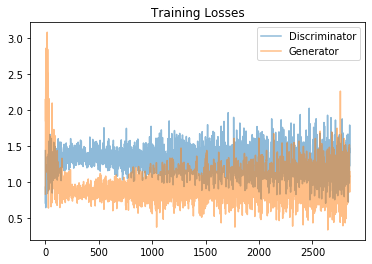

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [24]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [25]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

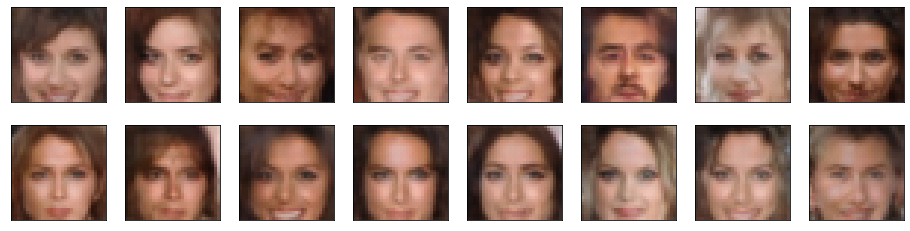

In [26]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 
To increase diversity in the output images the dataset would need to include more diverse images of people, and possibly be trained for longer or the model would need to be deeper to account for the increased complexity of the dataset.

The initial architecture conisted of 3 convolution/transpose convolution layers in the generator and discriminator. The faces appeared "waxy" - lacking in resolution and detail - so I thought a deeper model could potentially improve facial detail. Adding a 1x1 convolutional layer to the discriminator may have helped produce less smudged faces but the losses were slightly more divergent than without the 1x1 convolution.

In the initial architecture, I noticed the generator loss would begin to increase and diverge from the discriminator loss around epoch 4-5, and therefore the model was trained for no more than 4 epochs. However, for the second architecture the losses began to diverge around epoch 8.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.